                                                                            NOTEBOOK 2: Machine Learning Predictions                                                           

                                                          2nd Machine Learning Project - start2impact - Davide Miglietta

# California Housing: House Price Prediction

The scope of this project is to predict the median price house in the various California's blocks. A block group is a geographical unit (with a population tipically from 600 to 3000) containing Census data. In other words it is a district.

The dataset comes from the 1990 US Census.

This is the second notebook of the analysis, where various Machine Learning models have been compared to find the most performing one for regression prediction.

### The original dataset features are:

* **longitude:** block longitude (higher values: farther west)

* **latitude:** block latitude (higher values: farther north)

* **housing_median_agee:** median age of block houses (the higher the value, the older the houses)

* **total_rooms:** total rooms in a block

* **total_bedrooms:** total bedrooms in a block

* **population:** block population

* **households:** total households (a group of people living in a home unit, for example: a family)

* **median_income:** household median income (10,000 US Dollars)

* **ocean_proximity:** house location respect to the ocean (categorical)

* **median_house_value:** median house value (US Dollars) --> **TARGET**

To which have been added:

* **avg_household_size:** average households size

* **bedrooms_per_person:** average bedrooms per person

* **avg_rooms_per_house:** average number of rooms per house
    
* **ratio_dayrooms_bedrooms:** average ratio dayrooms (living, kitchen...) / bedrooms

## Table of contents:
1. [Libraries](#Libraries)


2. [Dataset_import](#Dataset_import)


3. [Features_selection](#Features_selection)


4. [Functions_Definition](#Functions_Definition)


5. [Machine_Learning_Regression](#Machine_Learning_Regression)
    - [Linear_Regression](#Linear_Regression)
    - [Ridge_Regression](#Ridge_Regression)
    - [Lasso_Regression](#Lasso_Regression)
    - [K-NN_Regression](#K-NN_Regression)
    - [Decision_Tree](#Decision_Tree)
    - [Random_Forest](#Random_Forest)
    - [SVR_Regression](#SVR_Regression)
    
    
6. [Models_Comparation](#Models_Comparation)
    
    
7. [Best_Model:_Random_Forest](#Best_Model:_Random_Forest)
    

8. [Conclusions](#Conclusions)

### Libraries

In [1]:
#import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#for feature scaling
from sklearn.preprocessing import MinMaxScaler

#split in train-test set
from sklearn.model_selection import train_test_split as split

#model evalutaion metrics
from sklearn import metrics

#for hyperparameters tuning
from sklearn.model_selection import RandomizedSearchCV

#for constructing distributions:
from scipy.stats import uniform
from scipy.stats import loguniform
from scipy.stats import randint

import math

### Dataset_import

In [2]:
CH_df = pd.read_csv('CH_df.csv')
print(CH_df.shape)
CH_df.head()

(20525, 18)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,avg_household_size,avg_rooms_per_house,ratio_dayrooms_bedrooms,bedrooms_per_person,oc_pr_<1H OCEAN,oc_pr_INLAND,oc_pr_ISLAND,oc_pr_NEAR BAY,oc_pr_NEAR OCEAN,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,2.555556,6.984127,5.821705,0.400621,0,0,0,1,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,2.109842,6.238137,5.418626,0.460641,0,0,0,1,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,2.802260,8.288136,6.721053,0.383065,0,0,0,1,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,2.547945,5.817352,4.421277,0.421147,0,0,0,1,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,2.181467,6.281853,4.810714,0.495575,0,0,0,1,0,342200.0


The cubic power of some features, that are considered important, have been introduced to emphatize their contribution on the predictions. 

*Note that this transformation **could** bring improvment only to some models such as SVR or linear regresion. It **does not** with models based on trees (decison tree or random forest). For practical reason, same subsets are tested with all models, but no improvments are expected when using trees.*

In [3]:
CH_df[['cubic_income']] = CH_df[['median_income']].apply(lambda x: np.power(x, 3))
CH_df[['cubic_latitude']] = CH_df[['latitude']].apply(lambda x: np.power(x, 3))
CH_df[['cubic_longitude']] = CH_df[['longitude']].apply(lambda x: np.power(x, 3))

print(CH_df.shape)

#set 'TARGET' column at the end 
end = len(CH_df.columns) - 1
last_col = CH_df.pop('median_house_value')
CH_df.insert(end, 'median_house_value', last_col)

CH_df.head(2)

(20525, 21)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,avg_household_size,avg_rooms_per_house,...,bedrooms_per_person,oc_pr_<1H OCEAN,oc_pr_INLAND,oc_pr_ISLAND,oc_pr_NEAR BAY,oc_pr_NEAR OCEAN,cubic_income,cubic_latitude,cubic_longitude,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,2.555556,6.984127,...,0.400621,0,0,0,1,0,577.010912,54353.799872,-1.826137e+06,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,2.109842,6.238137,...,0.460641,0,0,0,1,0,572.076387,54267.751656,-1.825689e+06,358500.0


### Features_selection

First the models have been tried with all the variables, then the features have been reduced and various combinations tried.

In [4]:
#print(CH_df.columns.values.tolist(), '\n')

columns = []

#a good combination has been found to be:

columns = [
    
            'longitude', 'latitude',
            #'cubic_latitude', 'cubic_longitude',
            #'housing_median_age', 
            'total_rooms', 'total_bedrooms', 'population', 'households', 
            'median_income',
            #'cubic_income',
            'avg_household_size', 'avg_rooms_per_house', 'bedrooms_per_person', 
            'ratio_dayrooms_bedrooms',  
            'oc_pr_<1H OCEAN', 'oc_pr_INLAND', 'oc_pr_ISLAND', 'oc_pr_NEAR BAY', 'oc_pr_NEAR OCEAN', 
            #'median_house_value'
            
            ]

columns

['longitude',
 'latitude',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'avg_household_size',
 'avg_rooms_per_house',
 'bedrooms_per_person',
 'ratio_dayrooms_bedrooms',
 'oc_pr_<1H OCEAN',
 'oc_pr_INLAND',
 'oc_pr_ISLAND',
 'oc_pr_NEAR BAY',
 'oc_pr_NEAR OCEAN']

#### Creating a X matrix of the features and a y array of the targets:

In [5]:
X = CH_df[columns].copy()
X.columns = columns
X.head(2)

,longitude,latitude,total_rooms,total_bedrooms,population,households,median_income,avg_household_size,avg_rooms_per_house,bedrooms_per_person,ratio_dayrooms_bedrooms,oc_pr_<1H OCEAN,oc_pr_INLAND,oc_pr_ISLAND,oc_pr_NEAR BAY,oc_pr_NEAR OCEAN
0,-122.23,37.88,880.0,129.0,322.0,126.0,8.3252,2.555556,6.984127,0.400621,5.821705,0,0,0,1,0
1,-122.22,37.86,7099.0,1106.0,2401.0,1138.0,8.3014,2.109842,6.238137,0.460641,5.418626,0,0,0,1,0


In [6]:
y = CH_df['median_house_value']
print(y.shape)
y

(20525,)


0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20520     78100.0
20521     77100.0
20522     92300.0
20523     84700.0
20524     89400.0
Name: median_house_value, Length: 20525, dtype: float64

#### Split in Train and Test Set:

In [7]:
X_train, X_test, y_train, y_test = split(X, y, test_size =.2, random_state=0) 

print(X.shape)
print(X_train.shape)
print(X_test.shape)

(20525, 16)
(16420, 16)
(4105, 16)


#### Dataset scaling:

- MinMaxScaler() has been used to mantain '0' and '1' in the 'dummies' columns.

- First it has been performed 'fit_transorm' on the train set. With this, the values for transformation has been obtained an then applied on the test set.


In [8]:
#dataset scaling
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
print(X_train)

X_test = scaler.transform(X_test)
print(X_test)

[[0.24501992 0.50851064 0.03238032 ... 0.         0.         0.        ]
 [0.18924303 0.63404255 0.03283817 ... 0.         0.         0.        ]
 [0.63645418 0.13510638 0.05519662 ... 0.         0.         0.        ]
 ...
 [0.20717131 0.60957447 0.02960777 ... 0.         1.         0.        ]
 [0.64541833 0.12234043 0.0816503  ... 0.         0.         0.        ]
 [0.82669323 0.08297872 0.00722389 ... 0.         0.         0.        ]]
[[0.19123506 0.55744681 0.09052755 ... 0.         1.         0.        ]
 [0.61952191 0.16276596 0.097726   ... 0.         0.         0.        ]
 [0.5189243  0.20638298 0.00801241 ... 0.         0.         0.        ]
 ...
 [0.62350598 0.17340426 0.07903037 ... 0.         0.         0.        ]
 [0.51693227 0.1787234  0.13832223 ... 0.         0.         1.        ]
 [0.60956175 0.16808511 0.03311797 ... 0.         0.         0.        ]]


### Functions_Definition

For the following part, two functions have been created in order to be re-used for all the models:
* **random_search():** applying randomized search to find the best hyperparameters
* **see_randomsearch_results():** visualize the obtained results

The first function uses RandomizedSearchCV() to randomly test ML models hyperparameters from a given interval (or combination). 

It differentiates from GridSearch() because GridSearch() tries all possible combinations for the given hyperparameters. So, it is very computationally expensive.

With RandomizedSearchCV() it is possible to set 'n_iter' that is the number of iterations to perform. RandomizedSearchCV() performs like GridSearch() or even better.

#### Some considerations:
* model and parameters are the model and the set of hyperparameters to be tested
* cv is the number of folds for cross-validation
* scoring is the metric that discriminates the parameters
* verbose is set to 50 to have a sense of the ongoing analysis
* a 'model_dict' is created to have all information organized in the same way for all the models

In [9]:
def random_search(model, parameters, k, scoring, N):
       
    rs = RandomizedSearchCV(model, parameters, cv = k, scoring = scoring, n_iter = N, verbose = 50, n_jobs = -1) 
    rs = rs.fit(X_train,y_train)
    
    #'model_dict' is a dictionary containing all results of RandomizedSearchCV() for easier consultation
    model_dict = {}
    model_dict['best_score'] = rs.best_score_
    model_dict['best_params'] = rs.best_params_
    
    model_dict['params'] = rs.cv_results_['params']
    model_dict['means'] = rs.cv_results_['mean_test_score']
    model_dict['stds'] = rs.cv_results_['std_test_score']
        
    model_dict['MAE_train'] = metrics.mean_absolute_error(y_train, rs.predict(X_train))
    model_dict['MSE_train'] = metrics.mean_squared_error(y_train, rs.predict(X_train))
    model_dict['RMSE_train'] = np.sqrt(metrics.mean_squared_error(y_train, rs.predict(X_train)))
    model_dict['r2_train'] = np.sqrt(metrics.r2_score(y_train, rs.predict(X_train)))
    
    model_dict['MAE_test'] = metrics.mean_absolute_error(y_test, rs.predict(X_test))
    model_dict['MSE_test'] = metrics.mean_squared_error(y_test, rs.predict(X_test))
    model_dict['RMSE_test'] = np.sqrt(metrics.mean_squared_error(y_test, rs.predict(X_test)))
    model_dict['r2_test'] = np.sqrt(metrics.r2_score(y_test, rs.predict(X_test)))
        
    best_model = rs.best_estimator_
    
    return best_model, model_dict

In [10]:
def see_randomsearch_results(x, model_dict, regr_model):
    
    print('Best Model:', regr_model)
    print('\nBest score ({}): {:.0f}'.format(scoring, model_dict['best_score']))
    
    #to organize in descending order the results of the RandomizedSearchCV()
    #and organize consequently the corresponding standard deviations and list of parameters
    zipped_lists = zip(list(model_dict['means']), list(model_dict['stds']), list(model_dict['params']))
    sorted_lists = sorted(zipped_lists, reverse = True)
    tuples = zip(*sorted_lists)
    sorted_means, sorted_stds, sorted_params = [ list(tuple) for tuple in  tuples]
    
    plt.figure(figsize=(20, 4))
    
    #plot a point corresponding to the score and a bar corresponding to the std dev for each group of parameters
    plt.errorbar(x, sorted_means, yerr=sorted_stds, fmt='o')
    plt.xticks(x)
    
    plt.show()

    print('Chart Legend:\n')
    
    for i in x:
        print('{} --> Hyperparameters: {}'.format(i, sorted_params[i]))

### Machine_Learning_Regression

In [11]:
#k-folds for cross validation
k = 10 

#print(metrics.SCORERS.keys())

#chosen evaluation metric
scoring = 'neg_mean_absolute_error' 
N = 200 #number of iterations (combination of hyperparameters)

#needed for plots
x = list(np.arange(0,N)) 

#### Linear_Regression

In [12]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression() 
parameters = {} #with no parameters: it is basically a cross validation

LR_model, LR_dict = random_search(regressor, parameters, k, scoring, 1)

LR_predictions = LR_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    3.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished

Done!


Best Model: LinearRegression()

Best score (neg_mean_absolute_error): -48836


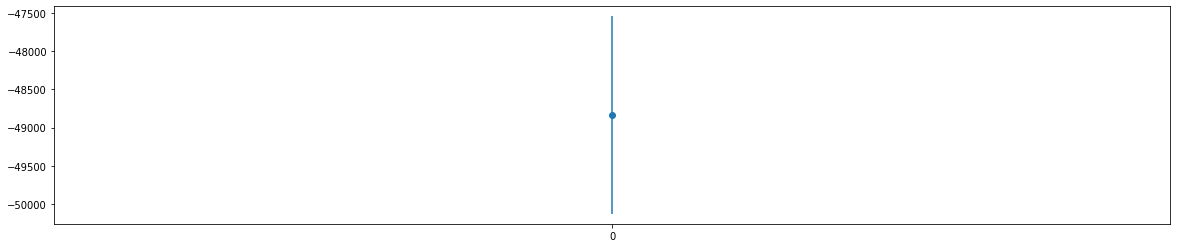

Chart Legend:

0 --> Hyperparameters: {}


In [13]:
see_randomsearch_results(np.arange(1), LR_dict, LR_model)

#### Ridge_Regression

In [14]:
"""
minimizzando questa funzione obiettivo si cerca di ottenere:
- un buon fit (lineare) dei dati di apprendimento
- scartando soluzioni "estreme" attraverso lo shrinkage dei parametri w dell'iperpiano
che si sta fittando sui dati; questo si ottiene appunto con l'aggiunta della regolarizzazione,
cioè di una penalità sulla norma del parametro w

in versione lasso, minimizzano la norma 0 invece della norma 2, invece di "strizzare"
alcuni coefficienti, questi si azzerano (prova a scrivere "ridge vs lasso" su google immagini
per un'interpretazione grafica)

la regolarizzazione ha sì effetto sulla scelta della soluzione (cioè dei coeffienti w),
ma non "automaticamente"; è piuttosto il prodotto dell'ottimizzazione dove la funzione
obiettivo è penalizzata dal termine di regolarizzazione, e quindi i coefficienti
sono "invogliati" a restare entro un certo valore

...spero di aver capito la tua domanda e averti risposto :D
"""

'\nminimizzando questa funzione obiettivo si cerca di ottenere:\n- un buon fit (lineare) dei dati di apprendimento\n- scartando soluzioni "estreme" attraverso lo shrinkage dei parametri w dell\'iperpiano\nche si sta fittando sui dati; questo si ottiene appunto con l\'aggiunta della regolarizzazione,\ncioè di una penalità sulla norma del parametro w\n\nin versione lasso, minimizzano la norma 0 invece della norma 2, invece di "strizzare"\nalcuni coefficienti, questi si azzerano (prova a scrivere "ridge vs lasso" su google immagini\nper un\'interpretazione grafica)\n\nla regolarizzazione ha sì effetto sulla scelta della soluzione (cioè dei coeffienti w),\nma non "automaticamente"; è piuttosto il prodotto dell\'ottimizzazione dove la funzione\nobiettivo è penalizzata dal termine di regolarizzazione, e quindi i coefficienti\nsono "invogliati" a restare entro un certo valore\n\n...spero di aver capito la tua domanda e averti risposto :D\n'

In [15]:
from sklearn.linear_model import Ridge

regressor = Ridge() 
parameters = {'alpha' : loguniform(1e-3, 1e3)}

ridge_model, ridge_dict = random_search(regressor, parameters, k, scoring, N)

ridge_predictions = ridge_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0648s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0957s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n

[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 912 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    7.1s
[Paral

[Parallel(n_jobs=-1)]: Done 1944 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1960 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1970 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1971 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1972 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1974 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1975 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1979 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1980 tasks      | elapsed: 

For Ridge Regression results are very similiar to simple linear regression. The best results, in fact, come with alpha close to zero.

Best Model: Ridge(alpha=0.07516983516971415)

Best score (neg_mean_absolute_error): -48817


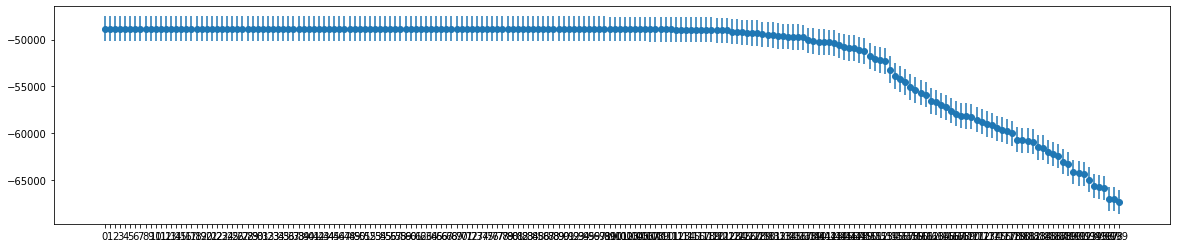

Chart Legend:

0 --> Hyperparameters: {'alpha': 0.07516983516971415}
1 --> Hyperparameters: {'alpha': 0.07404982944949359}
2 --> Hyperparameters: {'alpha': 0.07359742020730069}
3 --> Hyperparameters: {'alpha': 0.06733331763949794}
4 --> Hyperparameters: {'alpha': 0.06584853482963186}
5 --> Hyperparameters: {'alpha': 0.08631208443907035}
6 --> Hyperparameters: {'alpha': 0.0892942975269127}
7 --> Hyperparameters: {'alpha': 0.05794187055192676}
8 --> Hyperparameters: {'alpha': 0.053844046578758846}
9 --> Hyperparameters: {'alpha': 0.05378997739896405}
10 --> Hyperparameters: {'alpha': 0.10171811474298967}
11 --> Hyperparameters: {'alpha': 0.10371914493658484}
12 --> Hyperparameters: {'alpha': 0.105436250762204}
13 --> Hyperparameters: {'alpha': 0.045479554233684646}
14 --> Hyperparameters: {'alpha': 0.04482263463091474}
15 --> Hyperparameters: {'alpha': 0.1080677550630329}
16 --> Hyperparameters: {'alpha': 0.11475947817883503}
17 --> Hyperparameters: {'alpha': 0.035264490826086424}
18 -->

In [16]:
see_randomsearch_results(np.arange(N), ridge_dict, ridge_model)

In [17]:
from sklearn.linear_model import Lasso

regressor = Lasso() 
parameters = {'alpha' : loguniform(1e-3, 1e3)}

lasso_model, lasso_dict = random_search(regressor, parameters, k, scoring, N)

lasso_predictions = lasso_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   30.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 551 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:  2.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:  2.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 819 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:  3.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:  3.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1079 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1081 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1214 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1215 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1347 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1348 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1349 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1471 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1476 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1477 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1478 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1479 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1481 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1599 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1602 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1603 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1605 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1606 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1607 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1612 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1613 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1614 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1731 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1732 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1733 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1735 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1737 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1738 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1739 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1741 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1742 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1743 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1745 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1865 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1866 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1867 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1869 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1870 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1871 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1875 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1876 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1877 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1878 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1879 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed: 


Done!


With Lasso Regression also there is not big improvement, compared to simple linear regression.

Best Model: Lasso(alpha=4.7427607894447315)

Best score (neg_mean_absolute_error): -48810


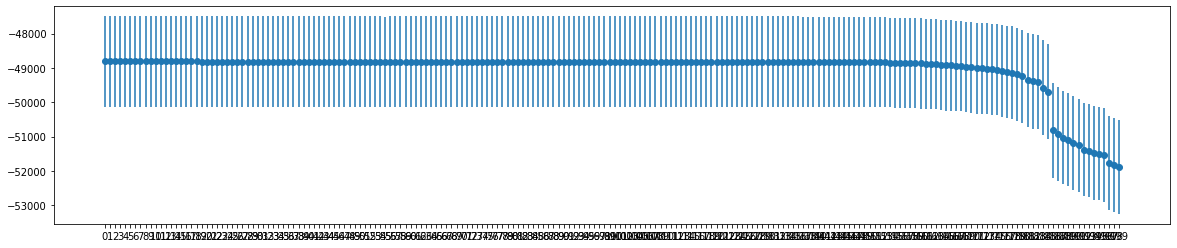

Chart Legend:

0 --> Hyperparameters: {'alpha': 4.7427607894447315}
1 --> Hyperparameters: {'alpha': 4.6774160617031715}
2 --> Hyperparameters: {'alpha': 4.466093080776431}
3 --> Hyperparameters: {'alpha': 4.173194295652653}
4 --> Hyperparameters: {'alpha': 3.835460381808604}
5 --> Hyperparameters: {'alpha': 3.661749520680129}
6 --> Hyperparameters: {'alpha': 5.872981770042183}
7 --> Hyperparameters: {'alpha': 3.4631871369810954}
8 --> Hyperparameters: {'alpha': 3.430074598220068}
9 --> Hyperparameters: {'alpha': 3.4225699509584686}
10 --> Hyperparameters: {'alpha': 3.2075859786482765}
11 --> Hyperparameters: {'alpha': 3.0459585904071838}
12 --> Hyperparameters: {'alpha': 3.045526349904072}
13 --> Hyperparameters: {'alpha': 6.56966132263179}
14 --> Hyperparameters: {'alpha': 6.87892826486881}
15 --> Hyperparameters: {'alpha': 2.6384855952374653}
16 --> Hyperparameters: {'alpha': 2.5223516138020323}
17 --> Hyperparameters: {'alpha': 2.400270198351286}
18 --> Hyperparameters: {'alpha': 2

In [18]:
see_randomsearch_results(np.arange(N), lasso_dict, lasso_model)

#### K-NN_Regression

In [19]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()

K_min = round(CH_df.shape[0] * 0.0005)
K_max = round(CH_df.shape[0] * 0.01)

parameters = {'n_neighbors': randint(K_min, K_max)}

KNN_model, KNN_dict = random_search(regressor, parameters, k, scoring, N)

KNN_predictions = KNN_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  2.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:  2.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:  3.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  3.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  4.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1079 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1081 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1214 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1215 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1331 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1333 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1340 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1463 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1465 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1471 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1473 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1476 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1477 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1478 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1597 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1599 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1602 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1603 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1604 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1605 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1606 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1607 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1612 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1729 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1731 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1732 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1733 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1734 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1735 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1737 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1738 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1739 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1741 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1742 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1743 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1862 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1863 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1864 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1865 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1866 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1867 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1868 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1869 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1870 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1871 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1875 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1991 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1993 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.3min finished

Done!


In general, as visible in the chart, the lower the number of neighbors the better the performance. At the same time, however, it is also higher the risk of overfitting. So, it is not possible to decrease too much the number of neighbors.

Best Model: KNeighborsRegressor(n_neighbors=13)

Best score (neg_mean_absolute_error): -37537


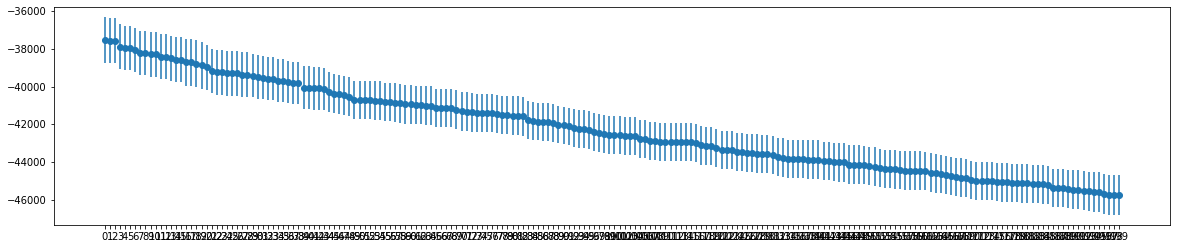

Chart Legend:

0 --> Hyperparameters: {'n_neighbors': 13}
1 --> Hyperparameters: {'n_neighbors': 14}
2 --> Hyperparameters: {'n_neighbors': 14}
3 --> Hyperparameters: {'n_neighbors': 18}
4 --> Hyperparameters: {'n_neighbors': 19}
5 --> Hyperparameters: {'n_neighbors': 19}
6 --> Hyperparameters: {'n_neighbors': 20}
7 --> Hyperparameters: {'n_neighbors': 22}
8 --> Hyperparameters: {'n_neighbors': 22}
9 --> Hyperparameters: {'n_neighbors': 23}
10 --> Hyperparameters: {'n_neighbors': 23}
11 --> Hyperparameters: {'n_neighbors': 25}
12 --> Hyperparameters: {'n_neighbors': 25}
13 --> Hyperparameters: {'n_neighbors': 26}
14 --> Hyperparameters: {'n_neighbors': 27}
15 --> Hyperparameters: {'n_neighbors': 27}
16 --> Hyperparameters: {'n_neighbors': 29}
17 --> Hyperparameters: {'n_neighbors': 29}
18 --> Hyperparameters: {'n_neighbors': 30}
19 --> Hyperparameters: {'n_neighbors': 31}
20 --> Hyperparameters: {'n_neighbors': 33}
21 --> Hyperparameters: {'n_neighbors': 36}
22 --> Hyperparameters: {'n

In [20]:
see_randomsearch_results(x, KNN_dict, KNN_model)

#### Decision_Tree

In [21]:
#verify what the 'min_samples_leaf' and 'min_samples_split' will be tested by tuning (min and max):
#math.ceil(CH_df.shape[0] * 0.0005) 
#math.ceil(CH_df.shape[0] * 0.25)

#verify what the 'max_depth' will be tested by tuning (min and max):
min_depth = round(CH_df.shape[0] * 0.0001)
max_depth = round(CH_df.shape[0] * 0.0005)

#np.arange(min_depth, max_depth)
#randint(min_depth, max_depth)

In [22]:
from sklearn.tree import DecisionTreeRegressor 

'''
Parameters:
- 'max depth': maximum depth of the tree (the higher the number, the higher the risk of overfitting)
- 'min_samples_leaf' : minimum numbers of samples in a leaf (if float --> fraction of samples)
- 'min_samples_split' : minimum number of samples required to split an internal node (if float --> fraction of samples)
'''

regressor = DecisionTreeRegressor()

parameters = {'max_depth': [2, 5, 10, 20, 50, None],
              'min_samples_leaf': loguniform(0.0005,0.25), 
             'min_samples_split': loguniform(0.0005,0.25) 
             }
    
DT_model, DT_dict = random_search(regressor, parameters, k, scoring, N)

DT_predictions = DT_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   12.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:   21.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 419 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:   32.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 551 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:   40.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 683 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 686 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 687 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 689 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 691 tasks      | elapsed:   47.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 814 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 817 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 819 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 822 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 823 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   54.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 955 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 957 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 958 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 959 tasks      | elapsed:  1.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1078 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1079 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1081 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1083 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1086 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1209 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1214 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1215 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1219 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1221 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1347 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1348 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1350 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1351 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1353 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1354 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1355 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1356 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1476 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1477 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1478 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1479 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1481 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1483 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1484 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1485 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1486 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1487 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1489 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1607 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1610 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1611 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1612 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1613 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1614 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1615 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1616 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1618 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1619 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1621 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1622 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1739 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1741 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1742 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1743 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1745 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1746 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1747 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1748 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1749 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1750 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1751 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1753 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1754 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1871 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1874 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1875 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1876 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1877 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1878 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1879 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1880 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1881 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1882 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1883 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1884 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1885 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1886 tasks      | elapsed: 

In [23]:
#see_randomsearch_results(x, DT_dict, DT_model)

#### Random_Forest

In [24]:
'''import math
math.ceil(CH_df.shape[0] * 0.0002)
math.ceil(CH_df.shape[0] * 0.01)''' #check for min_samples_leaf (and split)

'import math\nmath.ceil(CH_df.shape[0] * 0.0002)\nmath.ceil(CH_df.shape[0] * 0.01)'

In [25]:
#round(20 * 0.07) #check for max_features

In [26]:
from sklearn.ensemble import RandomForestRegressor 

regressor = RandomForestRegressor(random_state = 0)

parameters = {'n_estimators': [200, 300],
              'max_features': uniform(0.07, 0.5), #from 1 feature to half of the features
             #'min_samples_split': loguniform(0.0002,0.05),
              'min_samples_leaf':loguniform(0.0002,0.05)
             }

RF_model, RF_dict = random_search(regressor, parameters, k, scoring, N)

RF_predictions = RF_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 15.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 23.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 31.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed: 39.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 46.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 929 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 931 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 53.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed: 59.1min
[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed: 59.5min
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed: 59.5min
[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed: 59.8min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 1198 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 1199 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed: 66.4min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed: 66.5min
[Parallel(n_jobs=-1)]: Done 1203 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed: 67.0min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed: 73.6min
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 1326 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 1327 tasks      | elapsed: 73.8min
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed: 73.8min
[Parallel(n_jobs=-1)]: Done 1329 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 1331 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 1333 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 1335 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 1337 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 1338 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done 1339 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1455 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 1457 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed: 81.1min
[Parallel(n_jobs=-1)]: Done 1459 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 1460 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 1461 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 1463 tasks      | elapsed: 81.5min
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed: 81.5min
[Parallel(n_jobs=-1)]: Done 1465 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done 1467 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed: 82.0min
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-1)]: Done 1587 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-1)]: Done 1589 tasks      | elapsed: 87.8min
[Parallel(n_jobs=-1)]: Done 1590 tasks      | elapsed: 87.8min
[Parallel(n_jobs=-1)]: Done 1591 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 1592 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 1594 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 1595 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 1596 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 1597 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 1598 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 1599 tasks      | elapsed: 88.4min
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed: 88.4min
[Parallel(n_jobs=-1)]: Done 1601 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1717 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 1718 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 1719 tasks      | elapsed: 95.6min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed: 95.6min
[Parallel(n_jobs=-1)]: Done 1721 tasks      | elapsed: 95.8min
[Parallel(n_jobs=-1)]: Done 1722 tasks      | elapsed: 95.8min
[Parallel(n_jobs=-1)]: Done 1723 tasks      | elapsed: 96.0min
[Parallel(n_jobs=-1)]: Done 1724 tasks      | elapsed: 96.0min
[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed: 96.2min
[Parallel(n_jobs=-1)]: Done 1726 tasks      | elapsed: 96.2min
[Parallel(n_jobs=-1)]: Done 1727 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done 1729 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 1731 tasks      | elapsed: 96.6min
[Parallel(n_jobs=-1)]: Done 1732 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 1847 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 1849 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 1850 tasks      | elapsed: 103.6min
[Parallel(n_jobs=-1)]: Done 1851 tasks      | elapsed: 103.8min
[Parallel(n_jobs=-1)]: Done 1852 tasks      | elapsed: 103.9min
[Parallel(n_jobs=-1)]: Done 1853 tasks      | elapsed: 103.9min
[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed: 103.9min
[Parallel(n_jobs=-1)]: Done 1855 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 1857 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed: 104.2min
[Parallel(n_jobs=-1)]: Done 1859 tasks      | elapsed: 104.5min
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed: 104.5min
[Parallel(n_jobs=-1)]: Done 1861 tasks      | elapsed: 104.5min
[Parallel(n_jobs=-1)]: Done 1862 tasks  

[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed: 110.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 111.1min
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed: 111.1min
[Parallel(n_jobs=-1)]: Done 1979 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 1980 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 1982 tasks      | elapsed: 111.2min
[Parallel(n_jobs=-1)]: Done 1983 tasks      | elapsed: 111.3min
[Parallel(n_jobs=-1)]: Done 1984 tasks      | elapsed: 111.4min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed: 111.4min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed: 111.4min
[Parallel(n_jobs=-1)]: Done 1987 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 1988 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 1989 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 1990 tasks      | elapsed: 111.5min
[Parallel(n_jobs=-1)]: Done 1991 tasks  

In [28]:
#see_randomsearch_results(x, RF_dict, RF_model)

#### SVR_Regression

In [29]:
from sklearn.svm import SVR

regressor = SVR()

C_range = loguniform(1e-3, 1e3)
gamma_range = loguniform(1e-3, 1e3)
degree_range = np.arange(2,5)
epsilon_range = loguniform(1e-3, 1e3)

parameters = [
                {'kernel' : ['linear'], 'C' : C_range, 'epsilon': epsilon_range},
                {'kernel' : ['rbf'], 'C' : C_range, 'gamma' : gamma_range, 'epsilon': epsilon_range},
                {'kernel' : ['poly'], 'C' : C_range, 'degree' : degree_range, 'epsilon': epsilon_range}
                
             ]


SVR_model, SVR_dict = random_search(regressor, parameters, k, scoring, N)

SVR_predictions = SVR_model.predict(X_test)

print('\nDone!')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 30.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 45.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 57.5min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 57.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed: 70.6min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed: 70.6min
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed: 70.6min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 71.1min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 71.5min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed: 71.9min
[Paralle

[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 83.6min
[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed: 83.8min
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed: 83.8min
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed: 84.6min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 84.6min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed: 84.8min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 84.8min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 85.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 929 tasks      | elapsed: 104.1min
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed: 104.2min
[Parallel(n_jobs=-1)]: Done 931 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed: 105.0min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed: 105.1min
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed: 105.9min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed: 107.0min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed: 1

[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed: 129.5min
[Parallel(n_jobs=-1)]: Done 1059 tasks      | elapsed: 129.9min
[Parallel(n_jobs=-1)]: Done 1060 tasks      | elapsed: 129.9min
[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed: 130.0min
[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed: 130.1min
[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed: 130.5min
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed: 130.5min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed: 130.6min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed: 130.7min
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed: 131.1min
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed: 131.1min
[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed: 131.2min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed: 131.3min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed: 131.9min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed: 131.9min
[Parallel(n_jobs=-1)]: Done 1073 tasks  

[Parallel(n_jobs=-1)]: Done 1188 tasks      | elapsed: 146.3min
[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed: 146.6min
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed: 146.6min
[Parallel(n_jobs=-1)]: Done 1191 tasks      | elapsed: 146.7min
[Parallel(n_jobs=-1)]: Done 1192 tasks      | elapsed: 146.7min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 147.0min
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed: 147.1min
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed: 147.1min
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed: 147.2min
[Parallel(n_jobs=-1)]: Done 1197 tasks      | elapsed: 147.5min
[Parallel(n_jobs=-1)]: Done 1198 tasks      | elapsed: 147.5min
[Parallel(n_jobs=-1)]: Done 1199 tasks      | elapsed: 147.5min
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed: 147.6min
[Parallel(n_jobs=-1)]: Done 1201 tasks      | elapsed: 147.9min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed: 148.0min
[Parallel(n_jobs=-1)]: Done 1203 tasks  

[Parallel(n_jobs=-1)]: Done 1317 tasks      | elapsed: 160.3min
[Parallel(n_jobs=-1)]: Done 1318 tasks      | elapsed: 160.4min
[Parallel(n_jobs=-1)]: Done 1319 tasks      | elapsed: 160.4min
[Parallel(n_jobs=-1)]: Done 1320 tasks      | elapsed: 160.5min
[Parallel(n_jobs=-1)]: Done 1321 tasks      | elapsed: 160.8min
[Parallel(n_jobs=-1)]: Done 1322 tasks      | elapsed: 160.9min
[Parallel(n_jobs=-1)]: Done 1323 tasks      | elapsed: 160.9min
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed: 161.0min
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed: 161.4min
[Parallel(n_jobs=-1)]: Done 1326 tasks      | elapsed: 161.4min
[Parallel(n_jobs=-1)]: Done 1327 tasks      | elapsed: 161.5min
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed: 161.6min
[Parallel(n_jobs=-1)]: Done 1329 tasks      | elapsed: 161.8min
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed: 161.9min
[Parallel(n_jobs=-1)]: Done 1331 tasks      | elapsed: 161.9min
[Parallel(n_jobs=-1)]: Done 1332 tasks  

[Parallel(n_jobs=-1)]: Done 1446 tasks      | elapsed: 174.3min
[Parallel(n_jobs=-1)]: Done 1447 tasks      | elapsed: 174.6min
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed: 174.6min
[Parallel(n_jobs=-1)]: Done 1449 tasks      | elapsed: 174.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 174.8min
[Parallel(n_jobs=-1)]: Done 1451 tasks      | elapsed: 175.0min
[Parallel(n_jobs=-1)]: Done 1452 tasks      | elapsed: 175.0min
[Parallel(n_jobs=-1)]: Done 1453 tasks      | elapsed: 175.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 175.2min
[Parallel(n_jobs=-1)]: Done 1455 tasks      | elapsed: 175.3min
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed: 175.4min
[Parallel(n_jobs=-1)]: Done 1457 tasks      | elapsed: 175.5min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed: 175.6min
[Parallel(n_jobs=-1)]: Done 1459 tasks      | elapsed: 175.7min
[Parallel(n_jobs=-1)]: Done 1460 tasks      | elapsed: 175.8min
[Parallel(n_jobs=-1)]: Done 1461 tasks  

[Parallel(n_jobs=-1)]: Done 1575 tasks      | elapsed: 188.2min
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed: 188.2min
[Parallel(n_jobs=-1)]: Done 1577 tasks      | elapsed: 188.4min
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed: 188.5min
[Parallel(n_jobs=-1)]: Done 1579 tasks      | elapsed: 188.5min
[Parallel(n_jobs=-1)]: Done 1580 tasks      | elapsed: 188.6min
[Parallel(n_jobs=-1)]: Done 1581 tasks      | elapsed: 188.8min
[Parallel(n_jobs=-1)]: Done 1582 tasks      | elapsed: 188.9min
[Parallel(n_jobs=-1)]: Done 1583 tasks      | elapsed: 188.9min
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed: 189.0min
[Parallel(n_jobs=-1)]: Done 1585 tasks      | elapsed: 189.2min
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed: 189.3min
[Parallel(n_jobs=-1)]: Done 1587 tasks      | elapsed: 189.3min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed: 189.4min
[Parallel(n_jobs=-1)]: Done 1589 tasks      | elapsed: 189.6min
[Parallel(n_jobs=-1)]: Done 1590 tasks  

[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed: 200.8min
[Parallel(n_jobs=-1)]: Done 1705 tasks      | elapsed: 201.2min
[Parallel(n_jobs=-1)]: Done 1706 tasks      | elapsed: 201.2min
[Parallel(n_jobs=-1)]: Done 1707 tasks      | elapsed: 201.3min
[Parallel(n_jobs=-1)]: Done 1708 tasks      | elapsed: 201.3min
[Parallel(n_jobs=-1)]: Done 1709 tasks      | elapsed: 201.7min
[Parallel(n_jobs=-1)]: Done 1710 tasks      | elapsed: 201.7min
[Parallel(n_jobs=-1)]: Done 1711 tasks      | elapsed: 201.7min
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed: 201.7min
[Parallel(n_jobs=-1)]: Done 1713 tasks      | elapsed: 202.1min
[Parallel(n_jobs=-1)]: Done 1714 tasks      | elapsed: 202.1min
[Parallel(n_jobs=-1)]: Done 1715 tasks      | elapsed: 202.1min
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed: 202.1min
[Parallel(n_jobs=-1)]: Done 1717 tasks      | elapsed: 202.5min
[Parallel(n_jobs=-1)]: Done 1718 tasks      | elapsed: 202.5min
[Parallel(n_jobs=-1)]: Done 1719 tasks  

[Parallel(n_jobs=-1)]: Done 1833 tasks      | elapsed: 215.1min
[Parallel(n_jobs=-1)]: Done 1834 tasks      | elapsed: 215.1min
[Parallel(n_jobs=-1)]: Done 1835 tasks      | elapsed: 215.4min
[Parallel(n_jobs=-1)]: Done 1836 tasks      | elapsed: 215.4min
[Parallel(n_jobs=-1)]: Done 1837 tasks      | elapsed: 215.5min
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed: 215.5min
[Parallel(n_jobs=-1)]: Done 1839 tasks      | elapsed: 215.8min
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed: 215.8min
[Parallel(n_jobs=-1)]: Done 1841 tasks      | elapsed: 215.9min
[Parallel(n_jobs=-1)]: Done 1842 tasks      | elapsed: 215.9min
[Parallel(n_jobs=-1)]: Done 1843 tasks      | elapsed: 216.2min
[Parallel(n_jobs=-1)]: Done 1844 tasks      | elapsed: 216.2min
[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 216.3min
[Parallel(n_jobs=-1)]: Done 1846 tasks      | elapsed: 216.3min
[Parallel(n_jobs=-1)]: Done 1847 tasks      | elapsed: 216.6min
[Parallel(n_jobs=-1)]: Done 1848 tasks  

[Parallel(n_jobs=-1)]: Done 1962 tasks      | elapsed: 228.3min
[Parallel(n_jobs=-1)]: Done 1963 tasks      | elapsed: 228.4min
[Parallel(n_jobs=-1)]: Done 1964 tasks      | elapsed: 228.4min
[Parallel(n_jobs=-1)]: Done 1965 tasks      | elapsed: 228.6min
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed: 228.6min
[Parallel(n_jobs=-1)]: Done 1967 tasks      | elapsed: 228.7min
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed: 228.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 228.9min
[Parallel(n_jobs=-1)]: Done 1970 tasks      | elapsed: 228.9min
[Parallel(n_jobs=-1)]: Done 1971 tasks      | elapsed: 229.1min
[Parallel(n_jobs=-1)]: Done 1972 tasks      | elapsed: 229.1min
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed: 229.3min
[Parallel(n_jobs=-1)]: Done 1974 tasks      | elapsed: 229.3min
[Parallel(n_jobs=-1)]: Done 1975 tasks      | elapsed: 229.5min
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed: 229.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks  

see_randomsearch_results(x, SVR_dict, SVR_model)

### Models_Comparation

In this section the results obtained will be compared in order to find the model with the best performance.

In [30]:
#the following lists are creating for an easier iteration of the following part

#those three lists should be of the same length and contains model information in the same order
#then all the rest is 'automatically' arranged
models = ['Linear Regression', 'Ridge', 'Lasso', 'K-NN', 'Decision Tree', 'Random Forest', 'SVR']
dicts = [LR_dict, ridge_dict, lasso_dict, KNN_dict, DT_dict, RF_dict, SVR_dict]
regr_predictions = [LR_predictions, ridge_predictions, lasso_predictions, KNN_predictions, DT_predictions, RF_predictions, SVR_predictions]

metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'r2' ]
train_metrics = ['MAE_train', 'MSE_train', 'RMSE_train', 'r2_train']
test_metrics = ['MAE_test', 'MSE_test', 'RMSE_test', 'r2_test']

tableu_colors = list(mcolors.TABLEAU_COLORS.keys())


#### Results scatterplots:

On the left side:
- the graph shows the comparation between predicted values and real ones. Ideally the scatter plot should be close to the line y = x (perfect predictions)

On the right side:
- the graph shows the scatter plot of the residuals (predictions - real values) compared with the predictions. Ideally residuals are close to the line y = 0. In general, a good model has residuals with a normal distribution centered in zero (the more narrow the distribution, the better).

*Note that also for the next part the models will be plot with the same color for easier comparation*

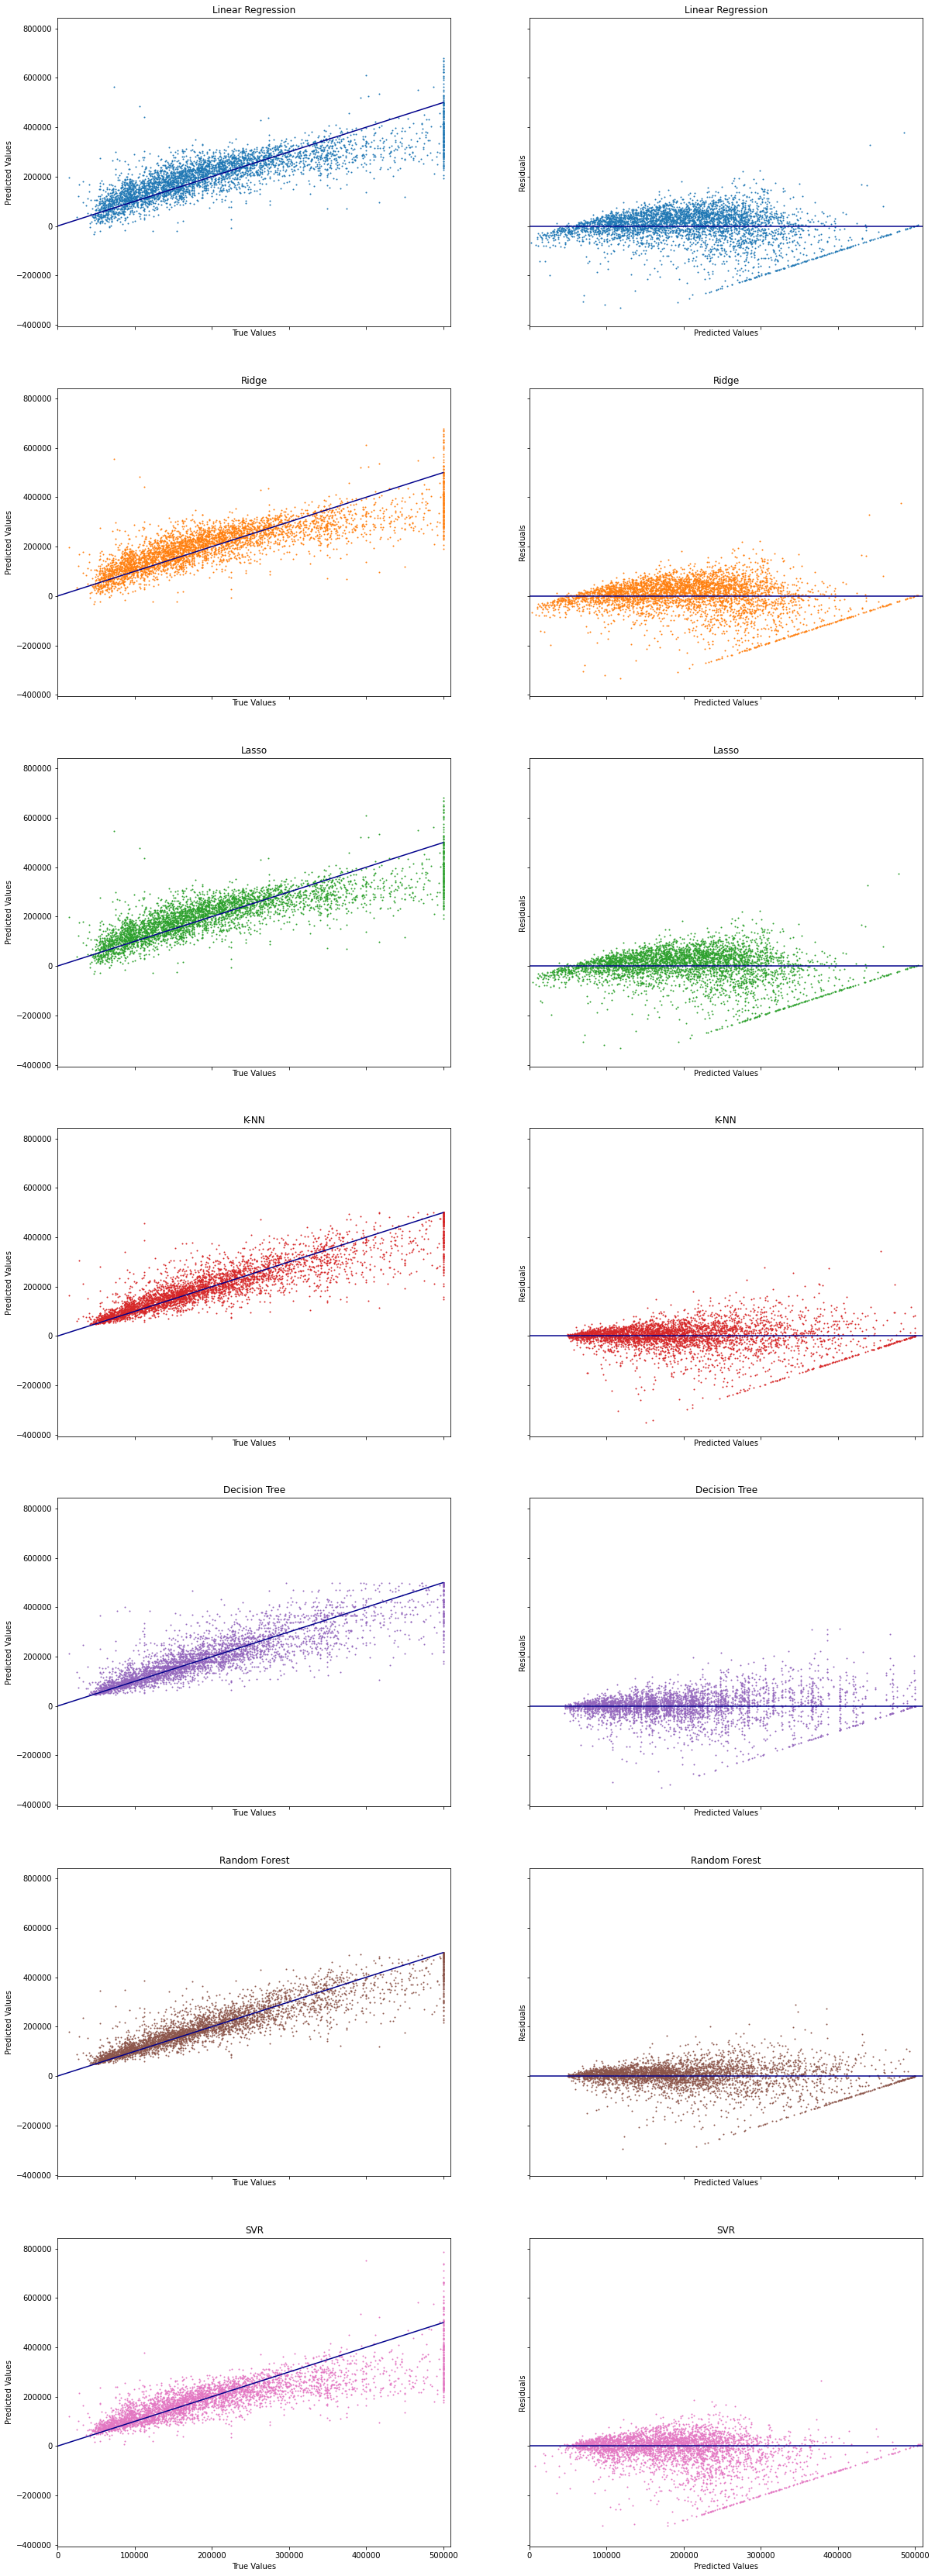

In [31]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 2, sharex = True, sharey=True, figsize = (20,60))

for pred, ax, color in zip(regr_predictions, axes, tableu_colors):
    
    ax1 = ax[0]
    ax1.scatter(y_test, regr_predictions[i], s=1, c = color)
    ax1.plot([0, 500000], [0, 500000], color='darkblue')
    
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(models[i])
    
    residuals = pred - y_test
    
    ax2 = ax[1]
    ax2.scatter(pred, residuals, s=1, c = color)
    ax2.axhline(color='darkblue')

    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(models[i])
    i = i + 1

plt.xlim([0,510000])
plt.show()

Some Considerations:

* For all models the it is visible that the True Values at 501,000 are not predicted well. On the left charts, corresponding to the value it is visible a 'vertical line' of dots. It corresponds, on the right charts, to the visible 'oblique line'.
* It also seems that, the models generally work better for predicting low values. While for high values the errors increase too. For this, it has been tried to use the 'mean squared error' as a scoring function. However it didn't result in a improvement in the models.

#### Residuals Distributions:

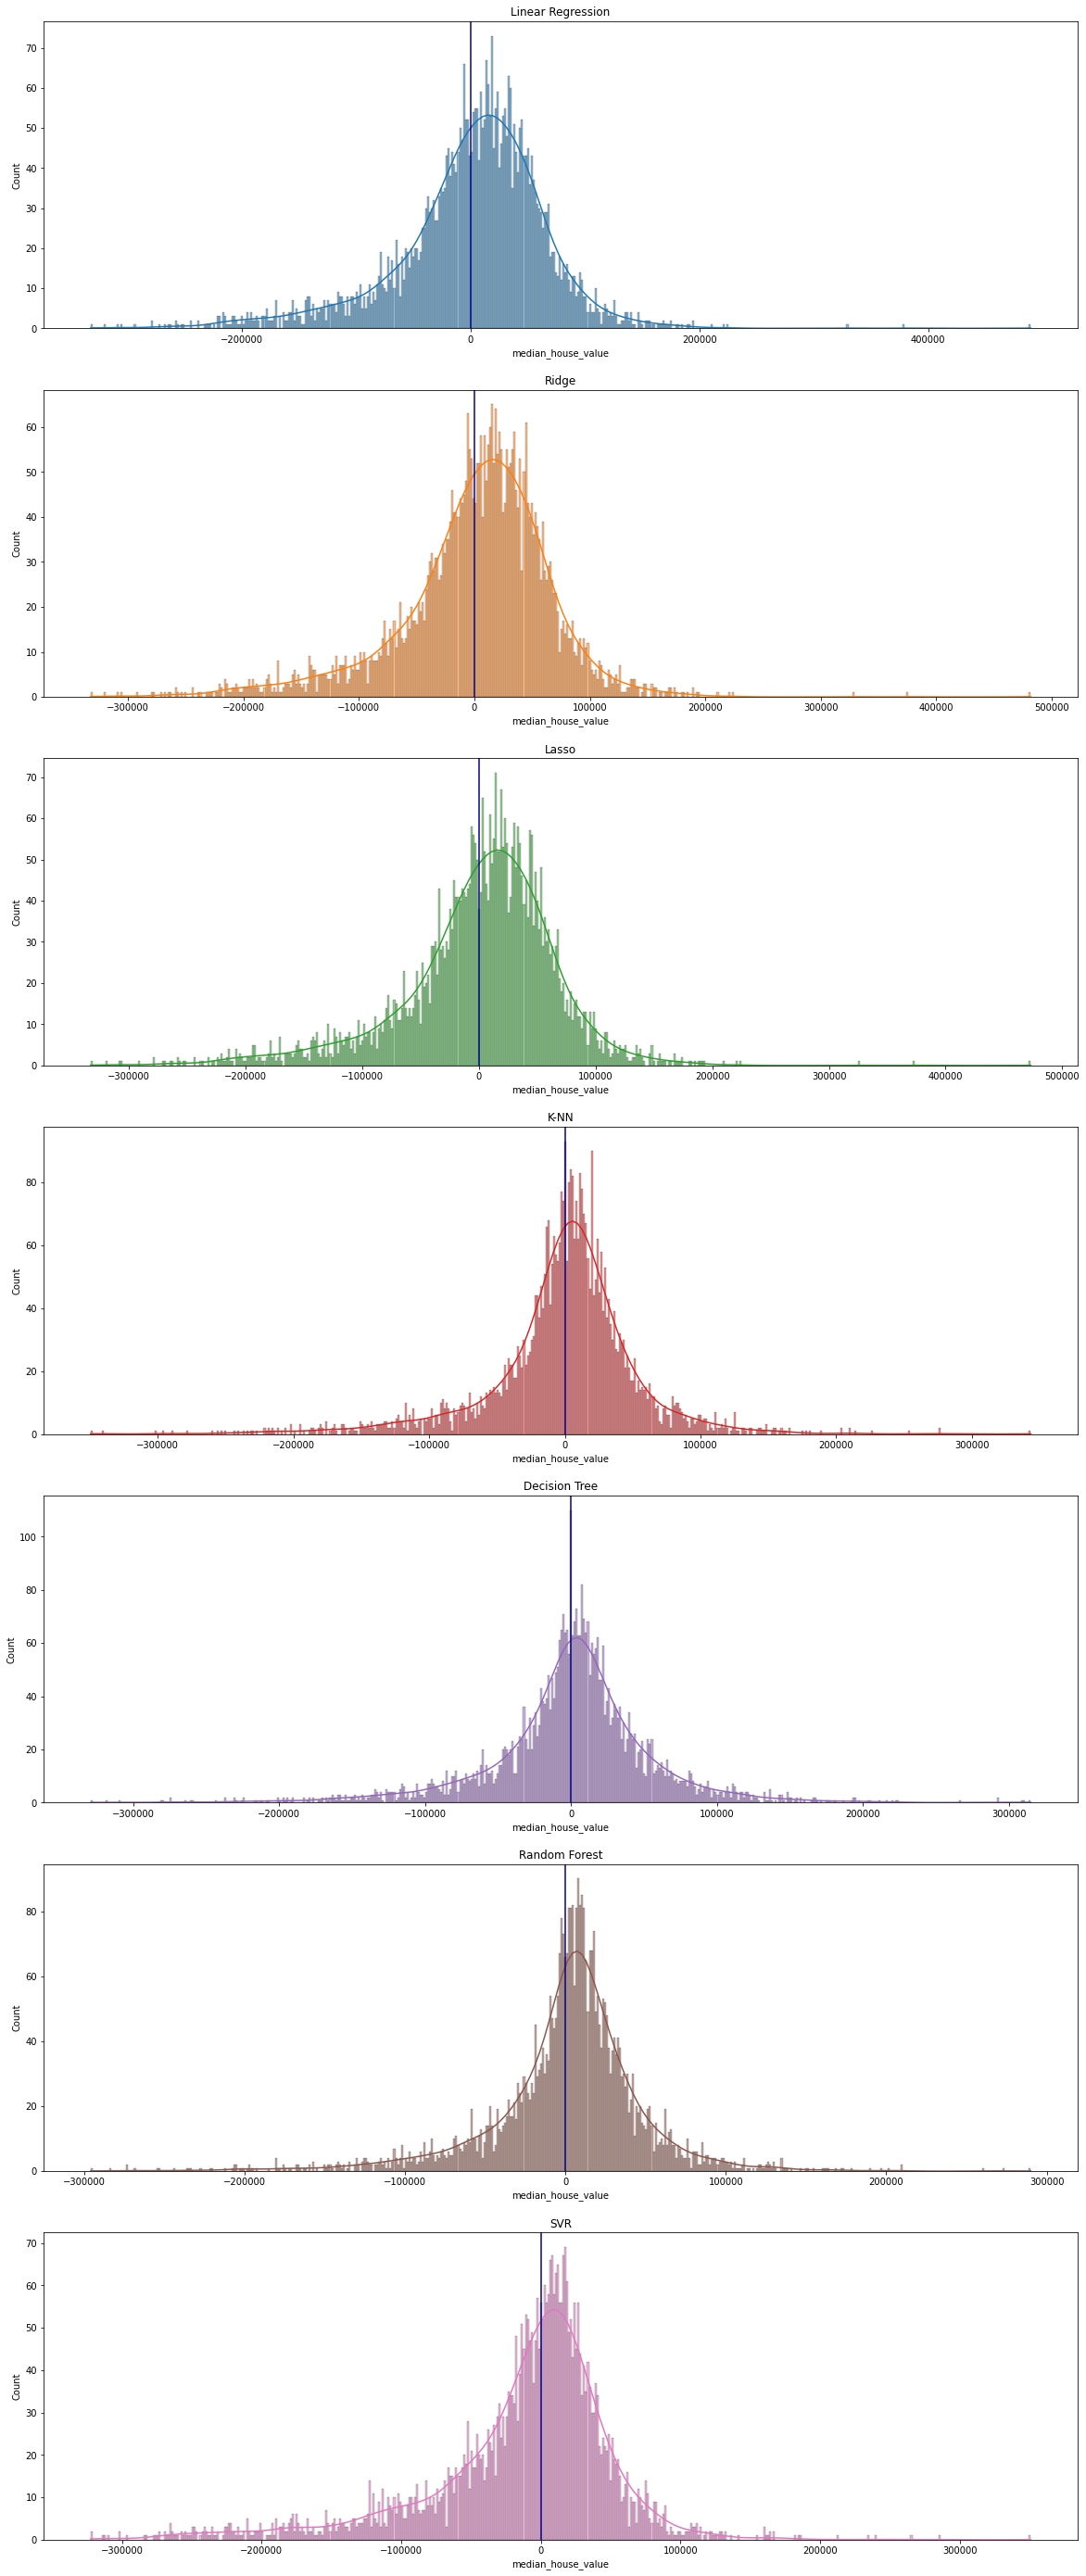

In [32]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 1, figsize = (20,50))

for pred, ax, color in zip(regr_predictions, axes, tableu_colors):
    residuals = pred - y_test
    sns.histplot(residuals, bins=500, kde = True, ax=ax, color=color)
    ax.axvline(color = 'darkblue')
    ax.set_title(models[i])
    i = i + 1

A good residuals distribution should be:
**centered in zero, normal and as narrow as possible** meaning that predictions are very close to true values and errors are distributed randomly.

From the distributions it seems that, the best model is K-NN. To confirm, let's compare the metrics in the next charts.

**Metrics Comparation**

- the circle marker refers to the Train Set
- the star marker refers to the Test Set

([<matplotlib.axis.XTick at 0x1c4862983d0>,
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Ridge'),
  Text(2, 0, 'Lasso'),
  Text(3, 0, 'K-NN'),
  Text(4, 0, 'Decision Tree'),
  Text(5, 0, 'Random Forest'),
  Text(6, 0, 'SVR')])

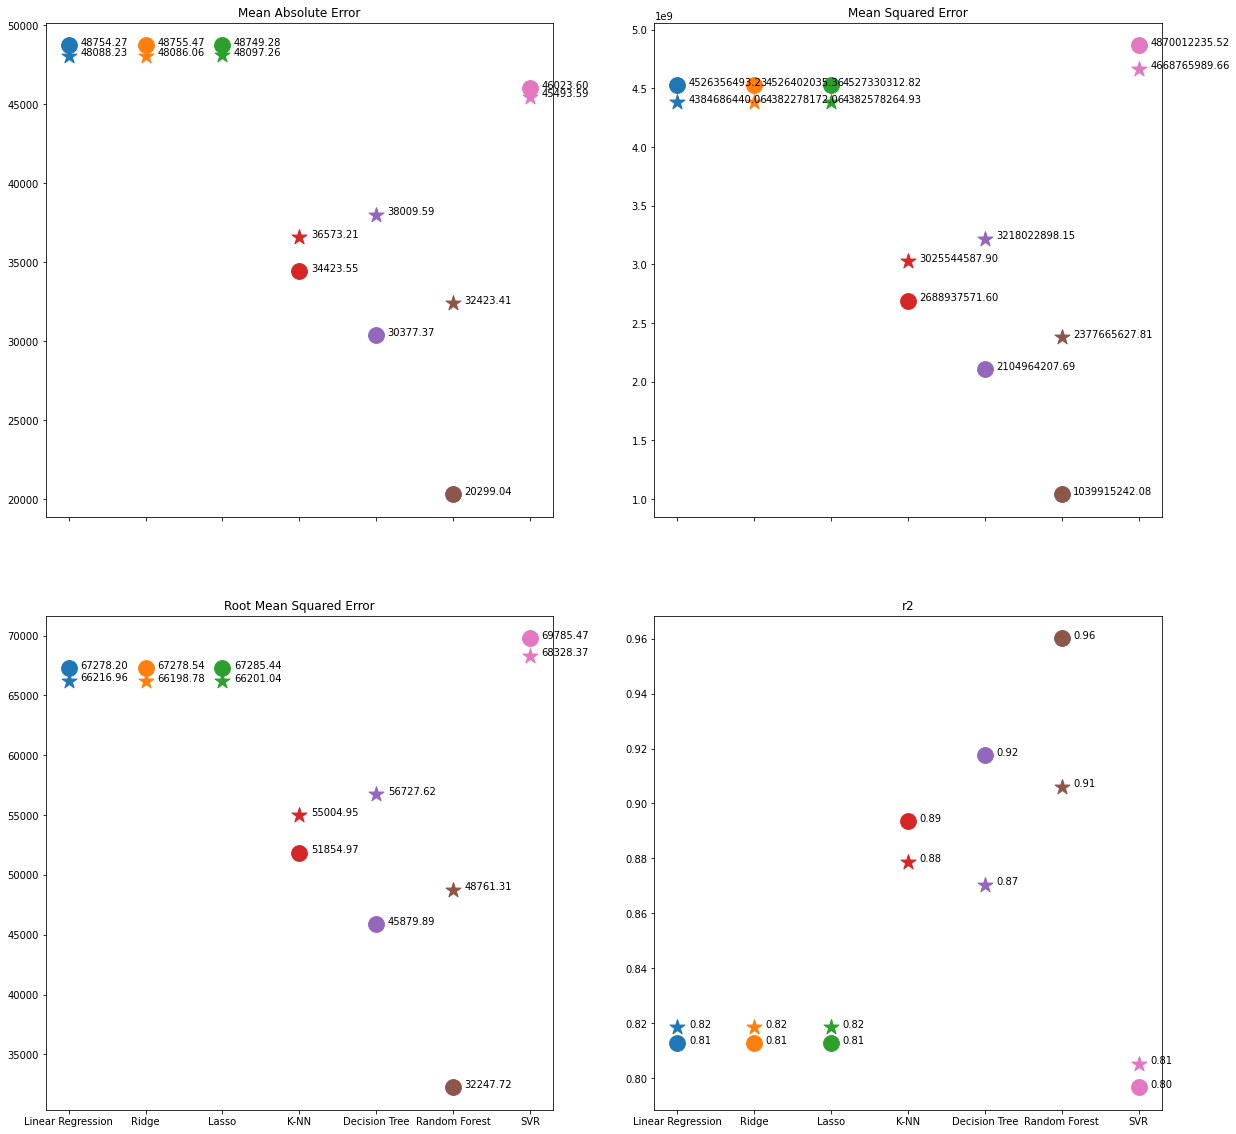

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex =True, figsize = (20,20))


for ax, train_metric, test_metric, metric in zip(axes.flat, train_metrics, test_metrics, metrics):
    
    for d, i, color, model in zip(dicts, range(len(dicts)), tableu_colors, models):
        
        #print('Model: {} - Metric: {} - Value: {:.2f}\n'.format(model, metric, d[train_metric]))
        
        ax.scatter(x = i, y = d[train_metric], marker = 'o', color = color, s = 250)
        ax.annotate(str('{:.2f}'.format(d[train_metric])),( i + 0.15, d[train_metric]))
        
        ax.scatter(x = i, y = d[test_metric], marker = '*', color = color, s = 250)
        ax.annotate(str('{:.2f}'.format(d[test_metric])),( i + 0.15, d[test_metric]))
        
        ax.set_title(metric)
        
plt.xticks(range(len(dicts)),models)




Metric comparation shows that Random Forest is the most performing model. Errors are lower and r2 higher.

However, it seems that overfitting is happening: performance on train set are sensibly better than on the test set.

#### Best_Model:_Random_Forest

Below, the graphs relative to RF will be shown again.

Moreover, in notebook 3 a classification is performed on the test set (same of the regression). The goal of the classification is to individuate 'max' house values (501000 $), that are bad predicted by the regression model. Those results will be combined with regression predictions.

In [39]:
RF_residuals = RF_predictions - y_test

(0.0, 510000.0)

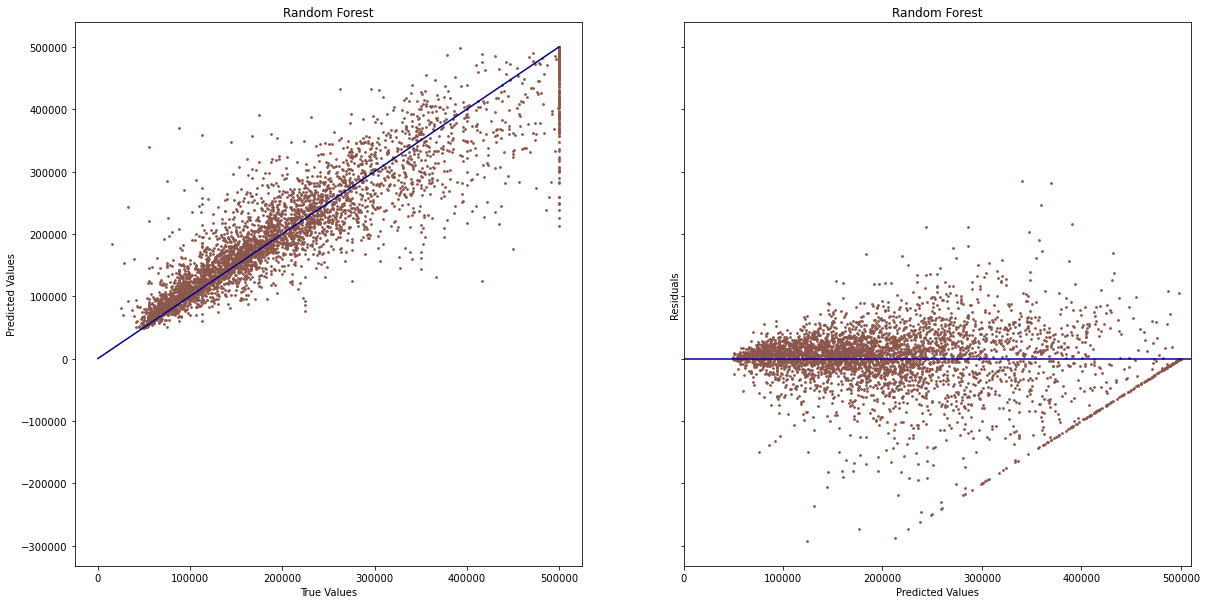

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey=True, figsize = (20,10))

ax1.scatter(y_test, RF_predictions, s=3, c = 'tab:brown')
ax1.plot([0, 500000], [0, 500000], color='darkblue')
    
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Random Forest')
   
ax2.scatter(RF_predictions, RF_residuals, s=3, c = 'tab:brown')
ax2.axhline(color='darkblue')

ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Random Forest')

plt.xlim([0,510000])

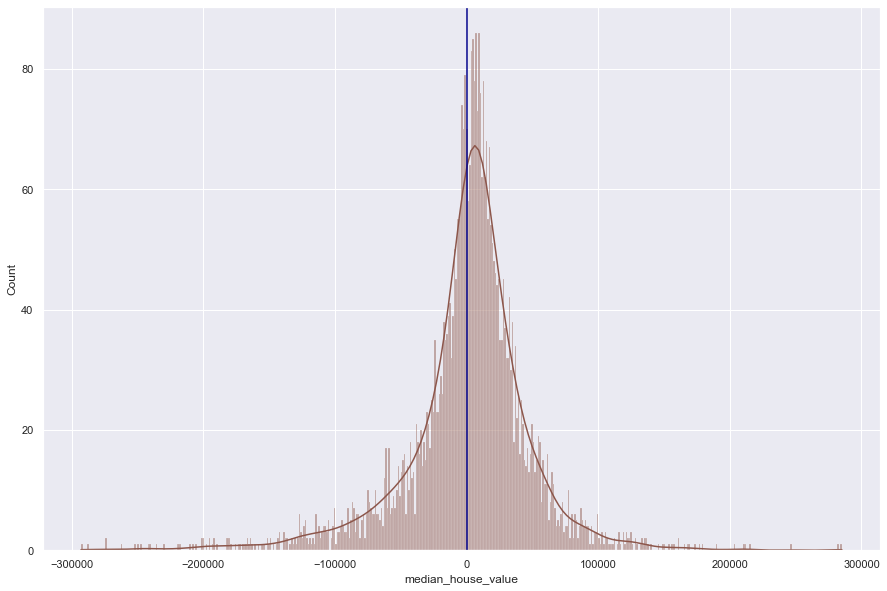

In [41]:
sns.set(rc={'figure.figsize':(15,10)})

sns.histplot(RF_residuals, bins=500, kde = True, color='tab:brown')
plt.axvline(color = 'darkblue')

Import classification predictions:

In [42]:
class_pr = np.genfromtxt('y_test_classification.csv', delimiter = ',')
class_pr = class_pr.astype(int)
class_pr

array([0, 0, 1, ..., 0, 0, 0])

If for an example, classification prediction is 1, two approaches are possible:

* use 500001 $ as the prediction, no matter the regression result

* compute the mean between 500001 $ and the regression result

In [43]:
#print(len(RF_predictions))
#print(len(prova))

RF_predictions_modified = RF_predictions.copy()

for i in range(len(class_pr)):
    if class_pr[i] == 1:
        #print(i, 'yes')
        RF_predictions_modified[i] = 500001.0 #substitution
        #RF_predictions_modified[i] = (RF_predictions_modified[i] + 500001.0) / 2 #mean

        
#the new residuals are:
RF_residuals_modified = RF_predictions_modified - y_test

(0.0, 510000.0)

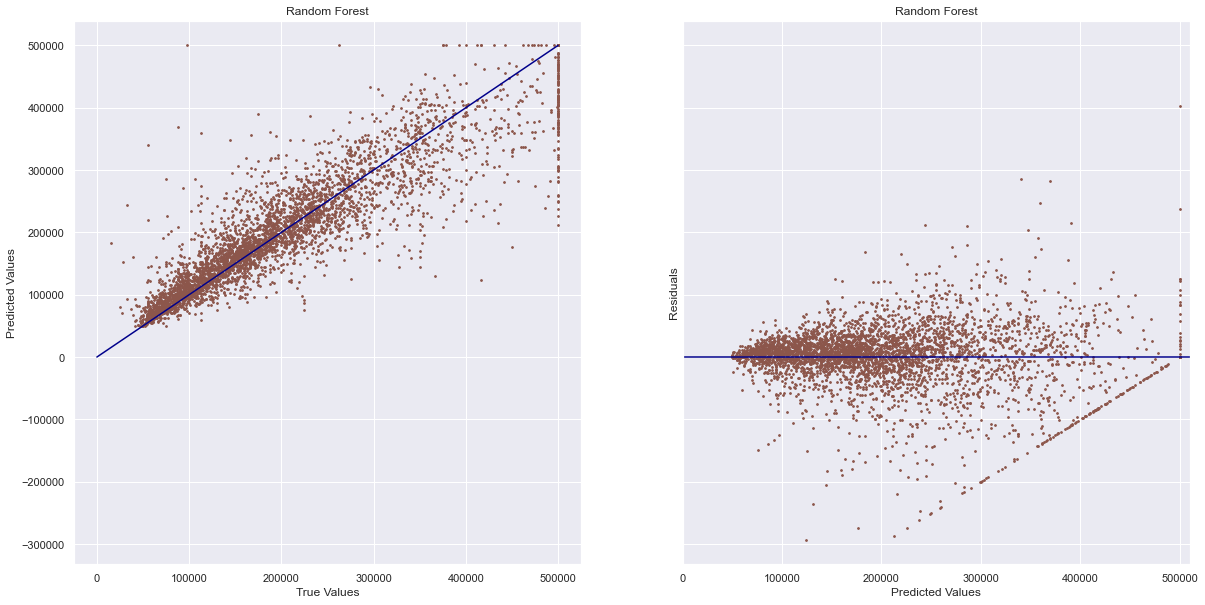

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey=True, figsize = (20,10))

ax1.scatter(y_test, RF_predictions_modified, s=3, c = 'tab:brown')
ax1.plot([0, 500000], [0, 500000], color='darkblue')
    
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Random Forest')
   
ax2.scatter(RF_predictions_modified, RF_residuals_modified, s=3, c = 'tab:brown')
ax2.axhline(color='darkblue')

ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Random Forest')

plt.xlim([0,510000])

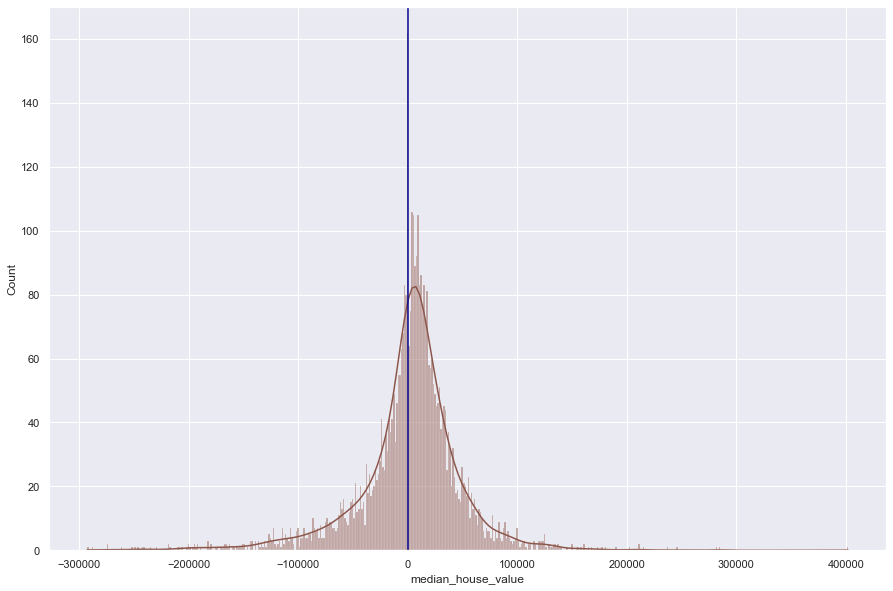

In [45]:
sns.set(rc={'figure.figsize':(15,10)})

sns.histplot(RF_residuals_modified, bins=500, kde = True, color='tab:brown')
plt.axvline(color = 'darkblue')

### Conclusions

After comparing various model the most performing has been found to be Random Forest regression. However, also its performances are not very satisfying considering the magnitude of errors compared to the true values.